In [1]:
from sklearn.metrics import confusion_matrix
from openai import OpenAI
from src.data_paths import *
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt


class TimeTrends():
    def __init__(self):
        self.cancer_well_studied_proteins = None
        self.df_bindingdb, self.df_doi = self.initialize_datasets()
        self.well_studied_proteins, self.well_studied_proteins_cancer_relationship = self.find_well_studied_proteins()
    
    def initialize_datasets(self):
        df_bindingdb = pd.read_pickle(BINDINGDB_CLEAN)
        df_doi = pd.read_pickle(DOI_DF_PATH)
        df_bindingdb['target_name_nonmutant'] = df_bindingdb['target_name'].apply(self._get_target_name_nonmutant)
        df_bindingdb['target_name'].nunique(), df_bindingdb['target_name_nonmutant'].nunique()

        return df_bindingdb, df_doi

    
    def find_well_studied_proteins(self):
        unique_prots = self.df_bindingdb['target_name_nonmutant'].unique()
        protein_to_doi = {prot: set() for prot in unique_prots}

        for _, row in self.df_bindingdb.iterrows():
            protein = row['target_name_nonmutant']
            doi = row['doi']
            protein_to_doi[protein].add(doi)
        MIN_ARTICLES = 500
        count = {prot: len(dois) for prot, dois in protein_to_doi.items()}
        well_studied_proteins = {prot: protein_to_doi[prot] for prot, count in count.items() if count >= MIN_ARTICLES}

        well_studied_proteins_cancer_relationship = {
            "Cytochrome P450 3A4": True,
            "Proto-oncogene tyrosine-protein kinase Src": True,
            "Epidermal growth factor receptor": True,
            "Vascular endothelial growth factor receptor 2": True,
            "D(2) dopamine receptor": False,
            "5-hydroxytryptamine receptor 1A": False,
            "5-hydroxytryptamine receptor 2A": False,
            "Acetylcholinesterase": False,
            "Cholinesterase": False,
            "Carbonic anhydrase 1": False,
            "Carbonic anhydrase 2": False,
            "Sodium-dependent serotonin transporter": False,
            "Prothrombin": False,
            "Adenosine receptor A2a": True,
            "Histone deacetylase 1": False,
            "Delta-type opioid receptor": False,
            "Mu-type opioid receptor": False,
            "Kappa-type opioid receptor": False,
            "Cytochrome P450 2C9": True,
            "Adenosine receptor A1": False,
            "Potassium voltage-gated channel subfamily H member 2": False,
            "Cannabinoid receptor 1": False,
            "Cytochrome P450 1A2": True,
            "Cytochrome P450 2C19": True,
            "Cytochrome P450 2D6": True,
            "Sodium-dependent dopamine transporter": False,
            "Prostaglandin G/H synthase 1": True,
            "Prostaglandin G/H synthase 2": True
        }
        return well_studied_proteins, well_studied_proteins_cancer_relationship

    ### We found that mutants are marked after a '[' in the target_name column
    def _get_target_name_nonmutant(self, x):
        return x.split('[')[0]

    ### Get API_KEY from environment variable
    @staticmethod
    def _get_api_key():
        api_key = os.getenv('SWISSAI_API')
        if not api_key:
            raise ValueError(
                """
                Error: SWISSAI_API environment variable not set
                Please set your API on Linux by running:
                export SWISSAI_API='your-api-key'
                """
            )
        api_key = api_key.strip() ## On windows very important!
        return api_key

    ### LLM requrest to decide if a protein is cancer related
    def _is_cancer_realted(self, protein):
        client = OpenAI(api_key=self._api_key)
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a pharmacological expert. You job is to review the following protein and answer the following quetion: Is research into binding affinity of this protein more likely to be cancer related, or not? Answer with 0 if it is not cancer related, and 1 if it is cancer related. Add no explanation, your answer should just be the digit."},
                {"role": "user", "content": protein}
                
            ],
            temperature=0
        )
        return True if completion.choices[0].message.content == "1" else False


    ######################
    #    VISUALIZATION   #
    ######################

    def visualize_chatgpt_confusion_matrix(self, get_metrics=True):

        ### Prepare the confusion matrix
        self._api_key = self._get_api_key()
        chatgpt_well_studied_proteins = {k: self._is_cancer_realted(k) for k in self.well_studied_proteins.keys()}
        true_positives = sum([1 for k, v in chatgpt_well_studied_proteins.items() if v and self.well_studied_proteins_cancer_relationship[k]])
        false_positives = sum([1 for k, v in chatgpt_well_studied_proteins.items() if v and not self.well_studied_proteins_cancer_relationship[k]])
        true_negatives = sum([1 for k, v in chatgpt_well_studied_proteins.items() if not v and not self.well_studied_proteins_cancer_relationship[k]])
        false_negatives = sum([1 for k, v in chatgpt_well_studied_proteins.items() if not v and self.well_studied_proteins_cancer_relationship[k]])

        
        ### Calculate confusion matrix
        conf_matrix = confusion_matrix([self.well_studied_proteins_cancer_relationship[k] for k in chatgpt_well_studied_proteins.keys()], list(chatgpt_well_studied_proteins.values()))
        plt.figure(figsize=(8, 6))
        plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')


        cbar = plt.colorbar()
        cbar.ax.set_ylabel('Frequency', rotation=270, labelpad=15)
        classes = ['Not Cancer Related', 'Cancer Related']
        plt.xticks(np.arange(len(classes)), classes, rotation=45, ha='right', fontsize=10)
        plt.yticks(np.arange(len(classes)), classes, fontsize=10)

        
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title('GPT-4 Chatbot Confusion Matrix', fontsize=14, pad=15)

        ### Each cell should have the count of the predictions
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                plt.text(j, i, f'{conf_matrix[i, j]}', 
                        ha='center', va='center', 
                        color='black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white', 
                        fontsize=10)

        
        plt.tight_layout()
        plt.show()

        ### Calculate precision, recall, and F1 score metrics
        if get_metrics:
            accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
            precision = true_positives / (true_positives + false_positives)
            recall = true_positives / (true_positives + false_negatives)
            f1_score = 2 * precision * recall / (precision + recall)
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.2f}")
            print(f"F1 Score: {f1_score:.2f}")
            print(f"Accuracy: {accuracy:.2f}")

    def visualize_monthly(self):
        ### Visualize the number of articles in BindingDB by month of publication

        ## Count the monthly articles
        month_value_counts = self.df_doi.dropna(subset=['month']).value_counts('month')
        month_value_counts.sort_index().plot(kind='bar') 

        ### Add average line
        avg = sum(month_value_counts)/12
        plt.axhline(avg, color='r', linestyle='dashed', linewidth=1, label='Average')
        
        plt.legend(['Average'])
        plt.xticks(rotation=45)
        plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.ylabel('Number of articles')
        plt.xlabel('Month of publication')
        plt.title('Number of articles in BindingDB by month of publication')

        
        month_published = self.df_doi.dropna(subset=['month'])

        ### Bootstrapping 95% confidence interval for the probability of january publication
        n = 1000
        january_proportion = []
        for _ in range(n):
            sample = month_published.sample(frac=1, replace=True)
            january_proportion.append((sample['month'] == 1).mean())

        print("95% CI for the probability of january publication: ", np.percentile(january_proportion, [2.5, 97.5]))
    
    def stacked_line_plot(self):
        ### Visualize the number of articles in BindingDB by year of publication in a stacked version
        
        plt.figure(figsize=(20, 10))
        keys_list = [k for k,v in self.well_studied_proteins_cancer_relationship.items() if v]
        manually_well_studied_proteins = {k: self.well_studied_proteins[k] for k in keys_list if k in self.well_studied_proteins}
        well_studied_proteins_all_dois = set().union(*manually_well_studied_proteins.values())


        df_doi_related = self.df_doi[self.df_doi.index.isin(well_studied_proteins_all_dois)]
        min_year = df_doi_related['year'].min()
        max_year = df_doi_related['year'].max()
        years = np.arange(min_year, max_year+1)
        max_y = 0
        

        all_counts_array = []
        for _,dois in manually_well_studied_proteins.items():
            df_doi_related = self.df_doi[self.df_doi.index.isin(dois)]
            
            df_doi_related = df_doi_related.dropna(subset=['year'], inplace=False)

            counts_some = df_doi_related.value_counts('year')
            counts_all = [counts_some[y] if y in counts_some.index else 0 for y in years]
            all_counts_array.append(counts_all)

            max_y = max(max_y, max(counts_all))

        plt.stackplot(years, all_counts_array, labels=manually_well_studied_proteins.keys())
        plt.ylabel('Number of scientific articles in BindingDB')
        plt.xlabel('Year of publication')
        plt.legend()
        plt.show()
    
    

In [2]:
timetrends = TimeTrends()

95% CI for the probability of january publication:  [0.08312318 0.08837635]


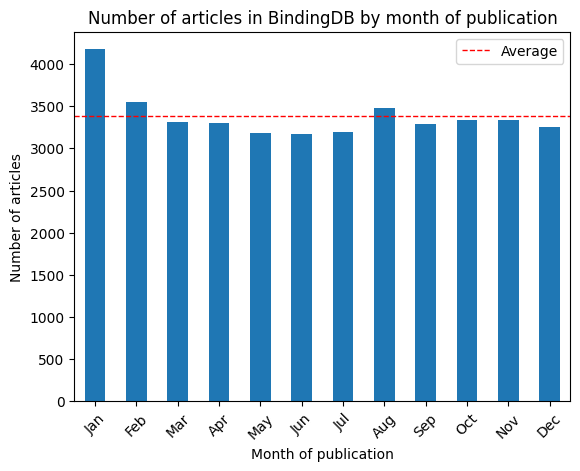

In [3]:
timetrends.visualize_monthly()

In [4]:
try:
    timetrends.visualize_chatgpt_confusion_matrix()
except Exception as e:
    print(e)


                Error: SWISSAI_API environment variable not set
                Please set your API on Linux by running:
                export SWISSAI_API='your-api-key'
                


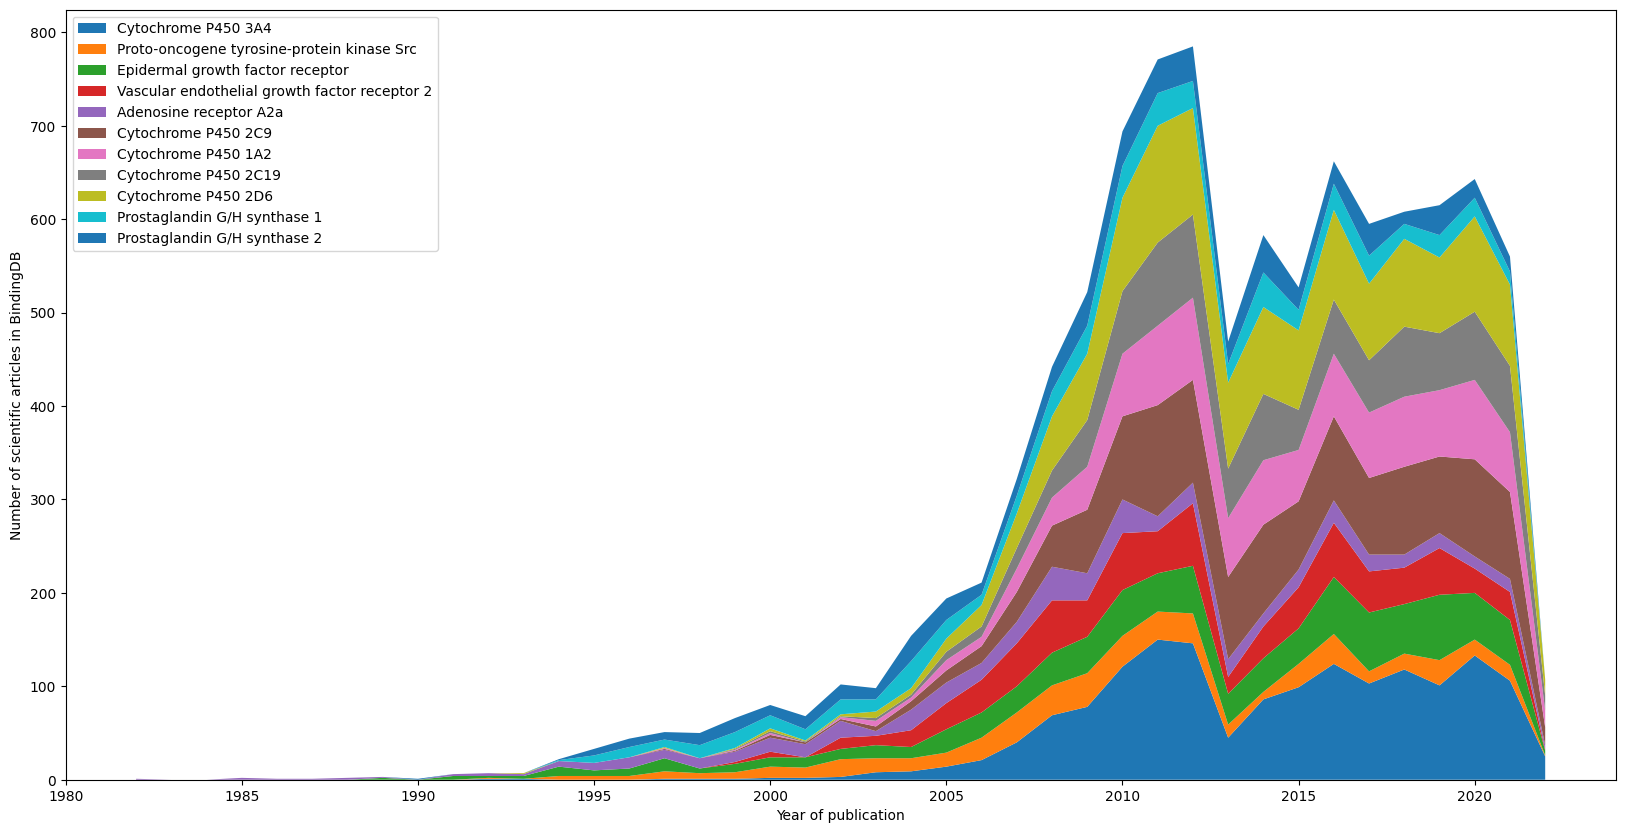

In [5]:
timetrends.stacked_line_plot()